Après avoir effectué un nettoyage approfondi des données et identifié les variables prédictives disponibles avant l'accouchement (lors de l'admission en salle de naissance), nous allons explorer différents modèles de classification en commençant par la régression logistique, qui offre une bonne interprétabilité. Notre variable cible binaire, hpp_trans (Hémorragie post-partum nécessitant une transfusion), présente un fort déséquilibre avec seulement 0.78% de cas positifs. Pour permettre au modèle de détecter efficacement le signal dans ces données déséquilibrées, nous allons tester plusieurs techniques de rééquilibrage.

Notre approche sera progressive :
1. Évaluation du modèle de base sans rééquilibrage
2. Test de différentes techniques de rééquilibrage (sur-échantillonnage de la classe minoritaire, sous-échantillonnage de la classe majoritaire et pondération des classes)
3. Optimisation des hyperparamètres via GridSearch en considérant le score F1 et le recall
 
Dans ce contexte médical où une mauvaise classification peut avoir des conséquences graves, nous privilégierons l'optimisation du recall tout en maintenant une précision acceptable. Les performances seront évaluées entre autres à l'aide des courbes ROC et precision-recall. Bien que le seuil de décision soit initialement fixé à 0.5, nous explorerons différents seuils pour optimiser les résultats.

In [84]:
# Bibliothèques standards
import logging
import os

# Bibliothèques de données et calcul scientifique
import joblib
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# MLflow
import mlflow
import mlflow.data.pandas_dataset
import mlflow.sklearn

# Scikit-learn - Prétraitement
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

# Scikit-learn - Modélisation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                   StratifiedKFold, train_test_split,cross_validate)
from sklearn.pipeline import Pipeline

# Scikit-learn - Métriques
from sklearn.metrics import (ConfusionMatrixDisplay, auc, classification_report,
                           f1_score, make_scorer, precision_recall_curve,
                           precision_score, recall_score, roc_auc_score,
                           roc_curve)

# Imbalanced-learn
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# XGBoost
from xgboost import XGBClassifier

In [3]:
df_dico = pd.read_csv('Project/clean/description_variable_clean.csv',index_col=0)
df_model = pd.read_csv('Project/clean/Bourgogne20132023_clean.csv', index_col=0)

In [4]:
# Fonction pour mettre à jour les listes de features en fonction du dictionnaire de variables
def update_list_features(X_train, df_dico):
    df_dico = df_dico.reindex(X_train.columns)
    quant_features = df_dico[df_dico['type_var'] == 'Quantitative'].index.tolist()
    binary_features = df_dico[df_dico['type_var'] == 'Binaire'].index.tolist()
    nominal_features = df_dico[df_dico['type_var'] == 'Nominale'].index.tolist()
    ordinal_features = df_dico[df_dico['type_var'] == 'Ordinale'].index.tolist()
    return quant_features, binary_features, nominal_features, ordinal_features

In [5]:
df_dico

,count,value_counts,nunique,min,max,description,type_var
bmi,53061,NaN,359,12.0,50.0,"L'indice de masse corporelle (IMC, ou BMI en a...",Quantitative
terme,65534,NaN,172,22.0,43.0,Terme à l'accouchement en semaine d aménorrhée...,Quantitative
dsm_g,65494,NaN,88,0.0,102.0,Duree hosp. pendant la grossesse,Quantitative
taille_mere,53227,NaN,55,109.0,190.0,Taille de la mére (en cm),Quantitative
age_m,65534,NaN,42,12.0,62.0,Age maternel calculé à partir de la date de na...,Quantitative
parite,54213,NaN,14,0.0,23.0,Parité obstétricale : nombre d'enfants issues ...,Quantitative
nbilan,65534,NaN,12,0.0,16.0,Nb bilans au cours de la grossesse,Quantitative
hosp_m_g,65534,NaN,10,0.0,9.0,Hosp. pendant la grossesse (0 : Non/1 : Oui),Quantitative
nsej18,65534,"{0: 61524, 1: 3477, 2: 416, 3: 88, 4: 20, 5: 7...",8,0.0,8.0,Nb sejours < 18 SA,Quantitative
AMP,65534,"{'Aucune': 64379, 'FIV': 353, 'FIV ICSI': 229,...",6,NaN,NaN,"Aide médicale à la procréation (FIV, ICSI, TEC...",Nominale


In [6]:
df_model=df_model.dropna()

X=df_model.drop(['hpp_trans'],axis=1)
y=df_model["hpp_trans"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

quant_features, binary_features, nominal_features, ordinal_features = update_list_features(X_train, df_dico)

print('Nombre de lignes et de colonnes de X_train : ',X_train.shape,'\n')


print(X_train[:5])

print("Quantitative features : ",quant_features)
print("Binaire features : ",binary_features)
print("Nominal features : ",nominal_features)
print("Ordinale features : ",ordinal_features)



Nombre de lignes et de colonnes de X_train :  (42350, 22) 

       age_m  taille_mere   bmi  tabac  parite  diabete  hta_tot  cholestase  \
45967   36.0        160.0  30.9      0     9.0        0        0           0   
1953    24.0        164.0  21.9      0     0.0        0        0           0   
9096    32.0        160.0  25.4      0     1.0        0        0           0   
43484   37.0        163.0  18.8      0     2.0        0        0           0   
44651   35.0        161.0  32.8      0     1.0        0        0           0   

       preecl  hellp  ...  ut_cica  cortico     AMP  pma hosp_m_g  dsm_g  \
45967       0      0  ...        1        0  Aucune    0        0    0.0   
1953        0      0  ...        0        0  Aucune    0        0    0.0   
9096        0      0  ...        1        0  Aucune    0        0    0.0   
43484       0      0  ...        0        1  Aucune    0        1    4.0   
44651       0      0  ...        0        0  Aucune    0        0    0.0   

  

In [84]:
# Création des transformateurs pour chaque type de variable

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=False))
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Création du preprocesseur avec ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, quant_features),
        ("bin", "passthrough", binary_features), 
        ('nom', nominal_transformer, nominal_features),
        ('ord', ordinal_transformer, ordinal_features)
    ])




In [59]:
def evaluate_model(model, X_train, X_test, y_train, y_test, experiment_name="Default", run_name="Default Run", use_mlflow=True):
    """
    Évalue un modèle entraîné et génère différents graphiques et métriques avec tracking MLflow optionnel
    """
    results = {}
    figures = []
    metrics = {}
    
    # Prédictions et probabilités
    y_prob_test = model.predict_proba(X_test)[:, 1]
    y_prob_train = model.predict_proba(X_train)[:, 1]
    
    # Prédictions avec seuil 0.5
    y_pred_test = (y_prob_test > 0.5).astype(int)
    y_pred_train = (y_prob_train > 0.5).astype(int)

    # Calcul des métriques de base
    metrics["recall_train"] = round(recall_score(y_train, y_pred_train), 4)
    metrics["precision_train"] = round(precision_score(y_train, y_pred_train), 4) 
    metrics["f1_train"] = round(f1_score(y_train, y_pred_train), 4)
    
    metrics["recall_test"] = round(recall_score(y_test, y_pred_test), 4)
    metrics["precision_test"] = round(precision_score(y_test, y_pred_test), 4)
    metrics["f1_test"] = round(f1_score(y_test, y_pred_test), 4)

    
    # Ajout des métriques pour les graphiques comparatifs

    results['precision_train'] = metrics['precision_train']
    results['precision_test'] = metrics['precision_test']
    results['recall_train'] = metrics['recall_train']
    results['recall_test'] = metrics['recall_test']
    results['f1_train'] = metrics['f1_train']
    results['f1_test'] = metrics['f1_test']
    results['model_name'] = run_name if run_name else model.__class__.__name__

    # Matrices de confusion
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, ax=ax)
    plt.title(f"Confusion Matrix - Train Set - {run_name}")
    figures.append(("01-confusion_matrix_train.png", fig))
    plt.show()

    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=ax)
    plt.title(f"Confusion Matrix - Test Set - {run_name}")
    figures.append(("02-confusion_matrix_test.png", fig))
    plt.show()

    # Courbes ROC
    fpr, tpr, _ = roc_curve(y_train, y_prob_train)
    metrics["roc_auc_train"] = round(roc_auc_score(y_train, y_prob_train), 4)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f"ROC curve (AUC = {metrics['roc_auc_train']:.4f})")
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve - Train Set - {run_name}")
    ax.legend()
    figures.append(("03-roc_curve_train.png", fig))
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    metrics["roc_auc_test"] = round(roc_auc_score(y_test, y_prob_test), 4)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f"ROC curve (AUC = {metrics['roc_auc_test']:.4f})")
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve - Test Set - {run_name}")
    ax.legend()
    figures.append(("04-roc_curve_test.png", fig))
    plt.show()

    # Courbes Precision-Recall
    train_precision, train_recall, _ = precision_recall_curve(y_train, y_prob_train)
    metrics["pr_auc_train"] = round(auc(train_recall, train_precision), 4)
    fig, ax = plt.subplots()
    ax.plot(train_recall, train_precision, lw=2, label=f"PR curve (AUC = {metrics['pr_auc_train']:.4f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision-Recall Curve - Train Set - {run_name}")
    ax.legend()
    ax.grid()
    figures.append(("05-precision_recall_curve_train.png", fig))
    plt.show()

    test_precision, test_recall, _ = precision_recall_curve(y_test, y_prob_test)
    metrics["pr_auc_test"] = round(auc(test_recall, test_precision), 4)
    fig, ax = plt.subplots()
    ax.plot(test_recall, test_precision, lw=2, label=f"PR curve (AUC = {metrics['pr_auc_test']:.4f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision-Recall Curve - Test Set - {run_name}")
    ax.legend()
    ax.grid()
    figures.append(("06-precision_recall_curve_test.png", fig))
    plt.show()

    # Test de différents seuils
    seuils = np.arange(0.1, 1.0, 0.1)
    recalls_test = []
    precisions_test = []
    f1_scores_test = []

    for seuil in seuils:
        y_pred_test = (y_prob_test > seuil).astype(int)
        recall = round(recall_score(y_test, y_pred_test, zero_division=0), 4)
        precision = round(precision_score(y_test, y_pred_test, zero_division=0), 4)
        f1 = round(f1_score(y_test, y_pred_test, zero_division=0), 4)
        
        recalls_test.append(recall)
        precisions_test.append(precision)
        f1_scores_test.append(f1)
        
        metrics[f"recall_test_seuil_{seuil:.1f}"] = recall
        metrics[f"precision_test_seuil_{seuil:.1f}"] = precision
        metrics[f"f1_test_seuil_{seuil:.1f}"] = f1

    # Graphique seuils
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(seuils, recalls_test, label="Recall", marker="o")
    ax.plot(seuils, precisions_test, label="Precision", marker="o")
    ax.plot(seuils, f1_scores_test, label="F1-Score", marker="o")
    ax.set_xlabel("Seuil de décision")
    ax.set_ylabel("Métrique")
    ax.set_title(f"Évolution des métriques en fonction du seuil (Test Set) - {run_name}")
    ax.legend()
    ax.grid(True)
    figures.append(("07-threshold_search.png", fig))
    plt.show()

    # Feature Importance
    try:
        if isinstance(model, GridSearchCV):
            best_model = model.best_estimator_
        else:
            best_model = model
            
        feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
        
        # Obtenir l'importance des features selon le type de modèle
        if hasattr(best_model.named_steps["classifier"], "coef_"):
            # Pour LogisticRegression
            importance = best_model.named_steps["classifier"].coef_[0]
            importance_type = "Coefficient"
        elif hasattr(best_model.named_steps["classifier"], "feature_importances_"):
            # Pour RandomForest et XGBoost
            importance = best_model.named_steps["classifier"].feature_importances_
            importance_type = "Importance"
        else:
            raise AttributeError("Le modèle ne supporte pas l'importance des features")

        feature_importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importance,
            "Absolute_Importance": np.abs(importance),
        }).sort_values(by="Absolute_Importance", ascending=False)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.barh(feature_importance_df["Feature"], feature_importance_df["Absolute_Importance"])
        ax.set_xlabel(f"Absolute {importance_type} Value")
        ax.set_ylabel("Feature")
        ax.set_title(f"Feature Importance - {best_model.named_steps['classifier'].__class__.__name__} - {run_name}")
        ax.invert_yaxis()
        plt.tight_layout()
        figures.append(("08-feature_importance.png", fig))
        plt.show()
    except (AttributeError, KeyError) as e:
        print(f"Impossible d'afficher l'importance des features: {str(e)}")

    # Classification reports
    report_train = classification_report(y_train, y_pred_train, zero_division=0)
    report_test = classification_report(y_test, y_pred_test, zero_division=0)

    # Enregistrement dans MLflow si use_mlflow est True
    if use_mlflow:
        mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "https://thibautmodrin-mlflow.hf.space"))
        mlflow.set_experiment(experiment_name)
        mlflow.sklearn.autolog(disable=True)
        
        with mlflow.start_run(run_name=run_name):
            # Log des paramètres
            mlflow.log_params(model.get_params())

            # Log du modèle
            if isinstance(model, GridSearchCV):
                best_model = model.best_estimator_
            else:
                best_model = model
                
            signature = mlflow.models.infer_signature(
                best_model.named_steps['preprocessor'].transform(X_train),
                best_model.predict(X_train)
            )
            mlflow.sklearn.log_model(best_model, best_model.__class__.__name__, signature=signature)
            
            # Log des datasets
            for col in X_train.select_dtypes(include=['int']).columns:
                X_train[col] = X_train[col].astype(float)
            y_train = y_train.astype(float)
            mlflow.log_input(mlflow.data.pandas_dataset.from_pandas(X_train, name="X_train"))
            mlflow.log_input(mlflow.data.pandas_dataset.from_pandas(pd.DataFrame(y_train), name="y_train"))
            
            # Log des métriques
            mlflow.log_metrics(metrics)
            
            # Log des figures
            for name, fig in figures:
                mlflow.log_figure(fig, name)
                
            # Log des rapports
            mlflow.log_text(report_train, "09-classification_report_train.txt")
            mlflow.log_text(report_test, "10-classification_report_test.txt")


    
    return results


In [38]:
# Suppression des avertissements liés à la dépréciation
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*_validate_data.*")
warnings.filterwarnings("ignore", message=".*_check_n_features.*")
warnings.filterwarnings("ignore", message=".*_check_feature_names.*")
warnings.filterwarnings("ignore", message=".*force_all_finite.*")
warnings.filterwarnings("ignore", message=".*ensure_all_finite.*")

### 1. Test du modèle de référence pour établir notre baseline

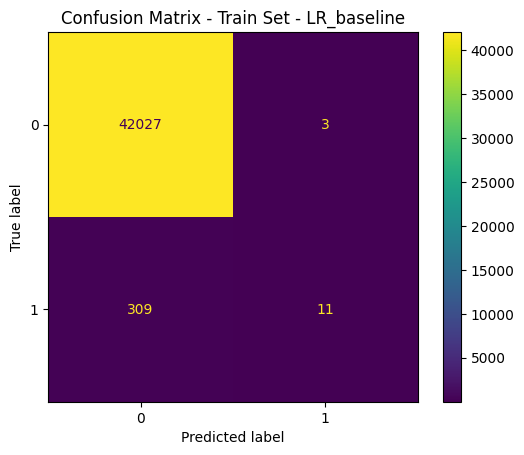

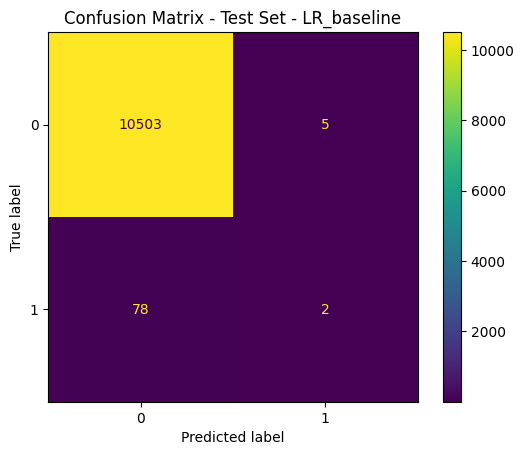

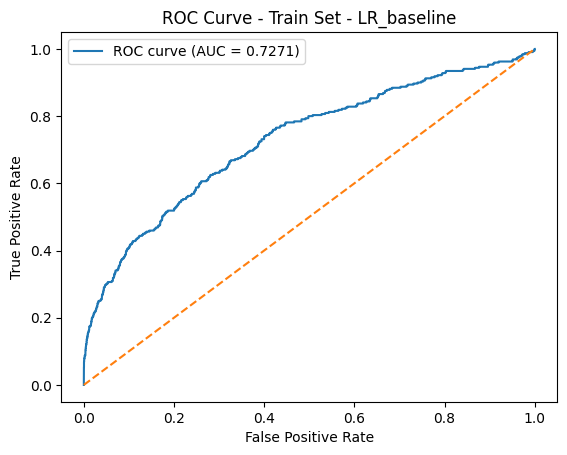

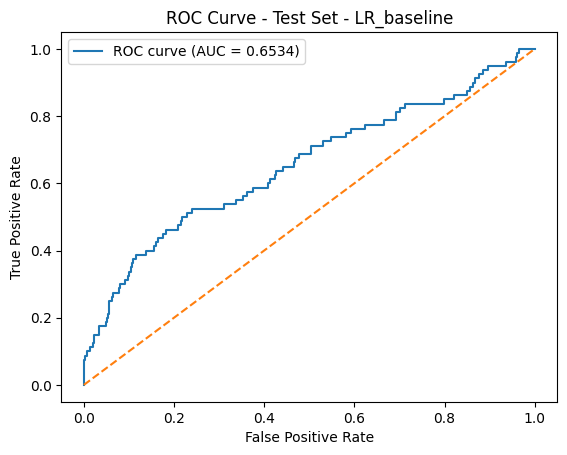

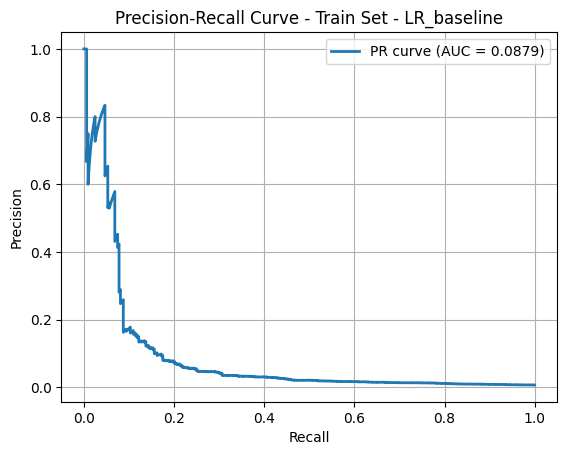

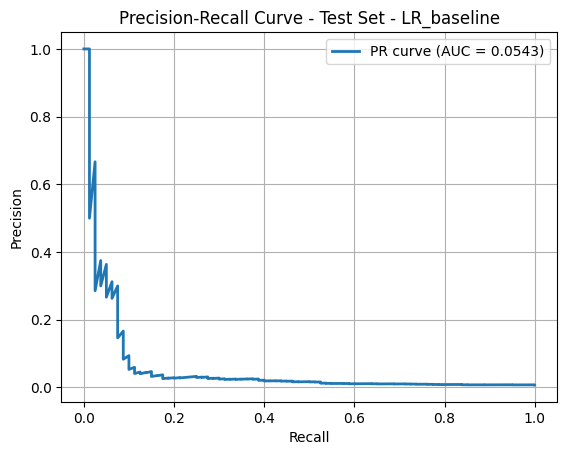

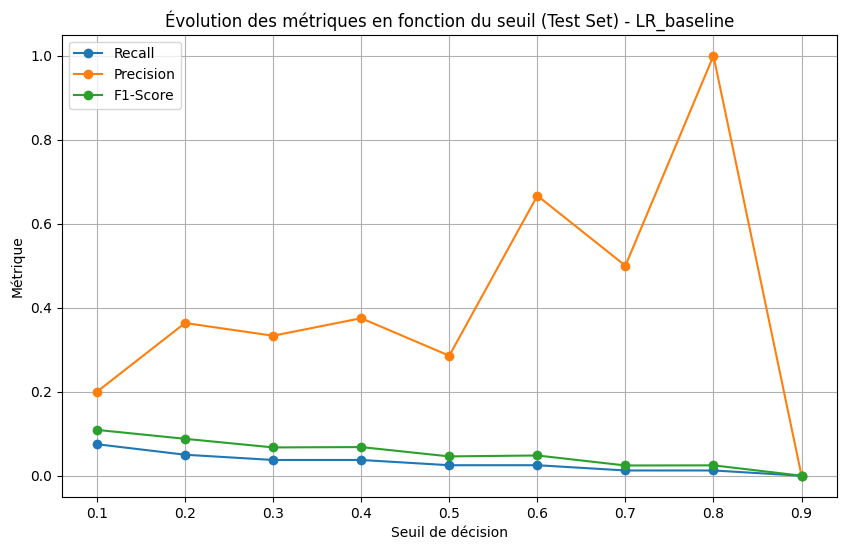

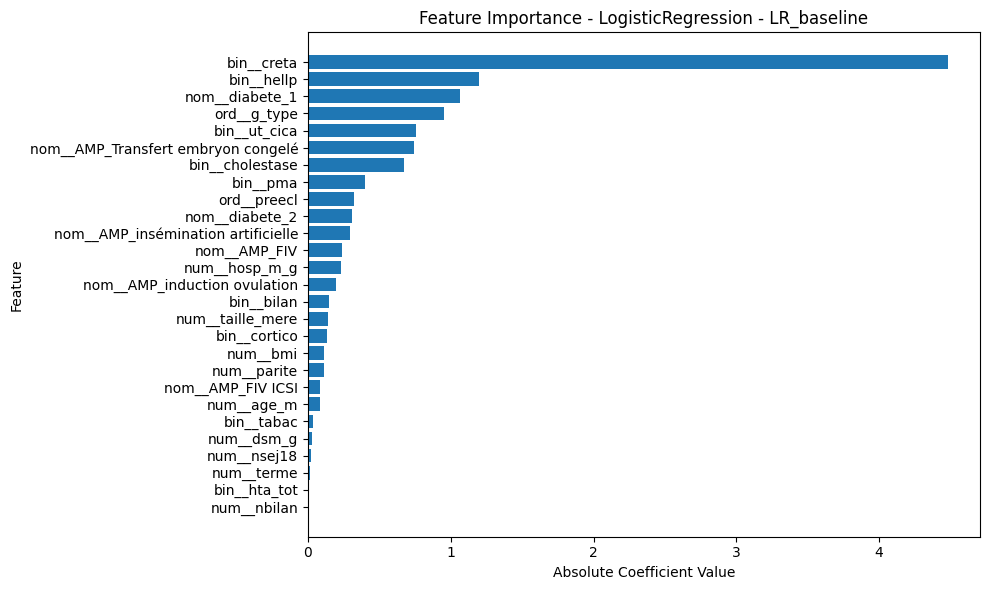

In [60]:
model = LogisticRegression(random_state=42,max_iter=1000)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])
param_grid = {
    
}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_reg_baseline=GridSearchCV(pipeline, param_grid, cv=cv, scoring='recall')
log_reg_baseline.fit(X_train,y_train)

# Évaluation du modèle baseline
baseline_results = evaluate_model(log_reg_baseline, X_train, X_test, y_train, y_test, 
                                experiment_name="LR_prediction", run_name="LR_baseline",use_mlflow=False)


### 2. Test de différentes techniques de rééquilibrage

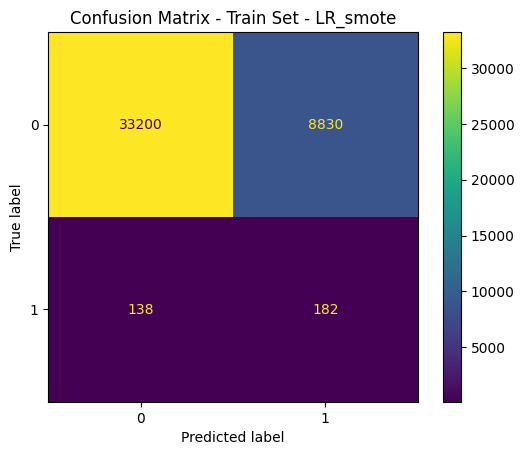

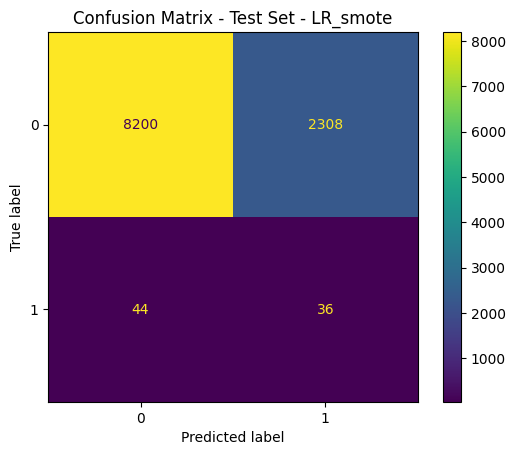

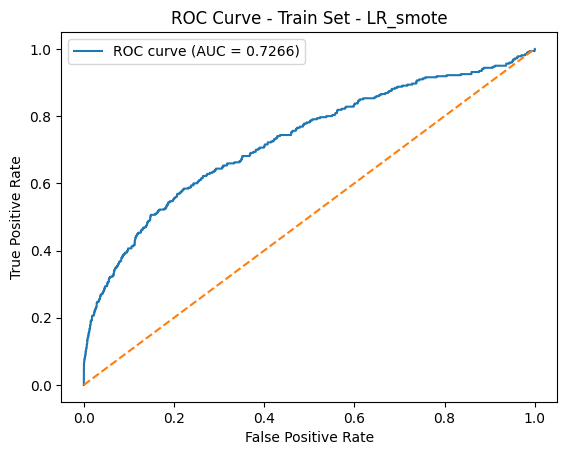

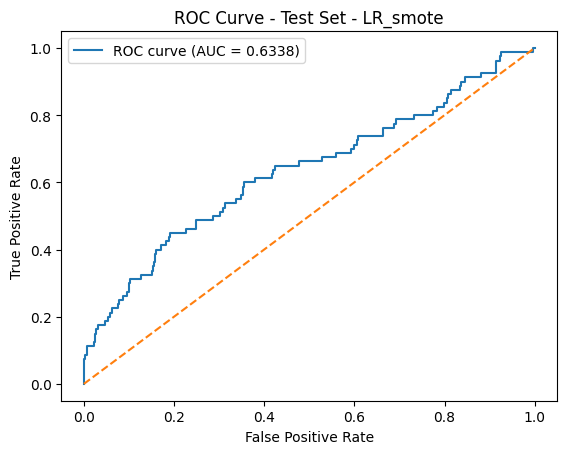

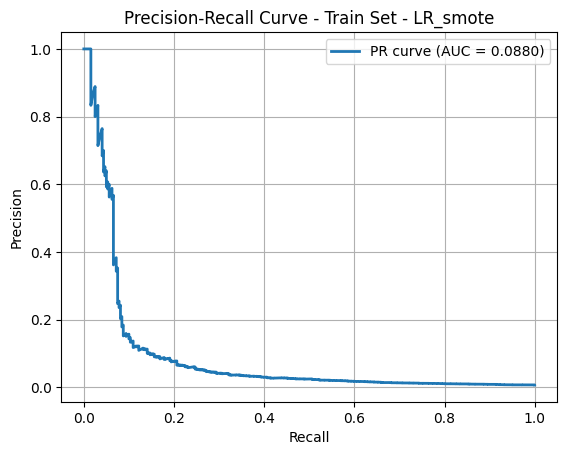

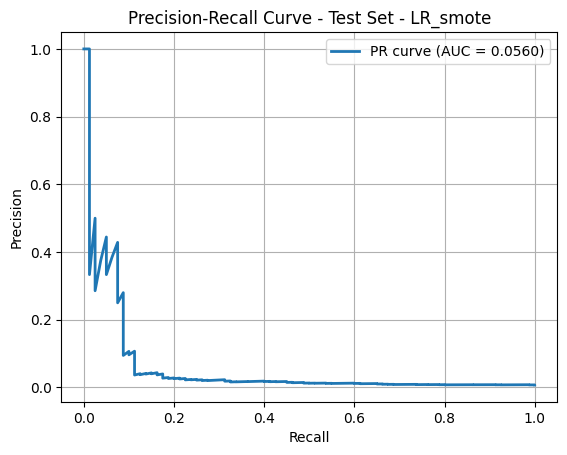

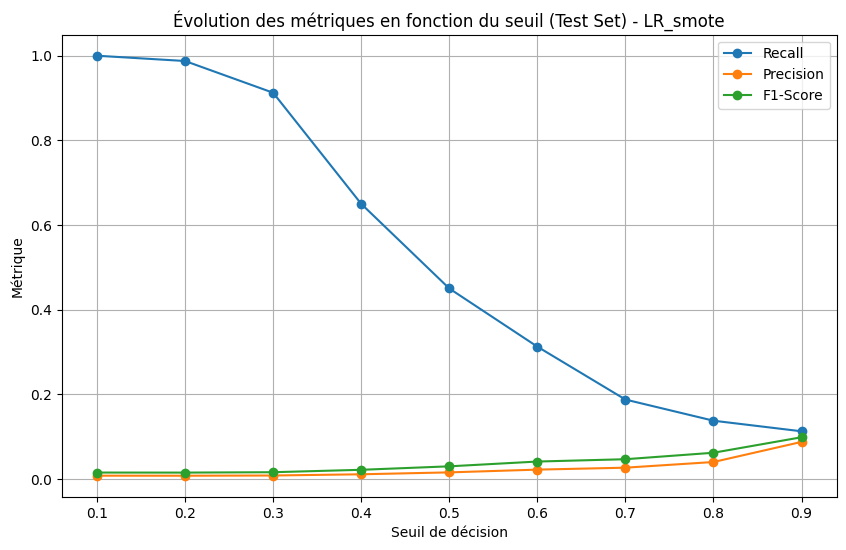

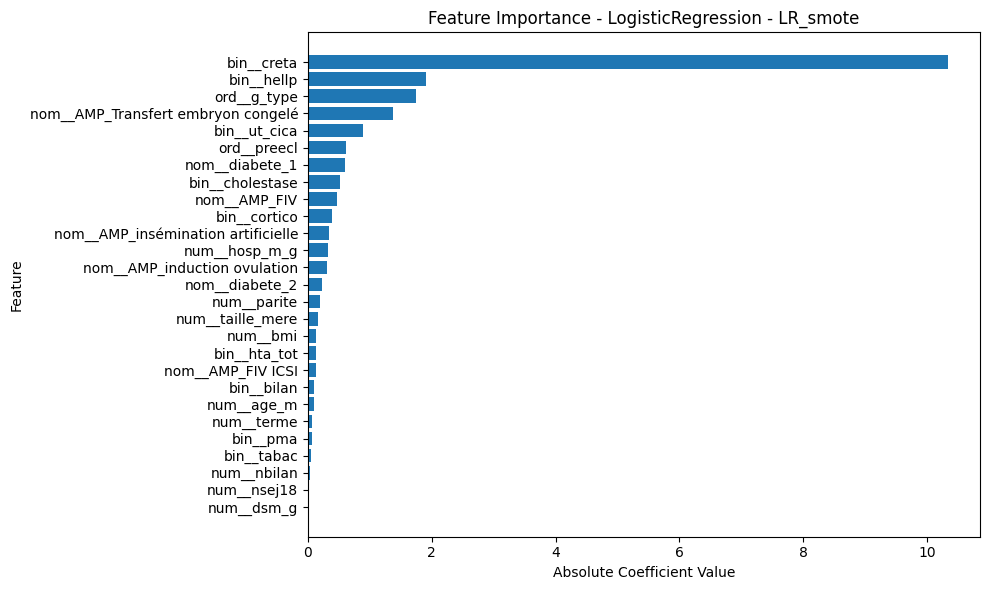

In [61]:
#### 2.1. Rééquilibrage par sur-échantillonnage de la classe minoritaire



# Pipeline avec SMOTE
pipeline_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42,max_iter=1000))
])

param_grid = {
    
}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_reg_smote=GridSearchCV(pipeline_smote, param_grid, cv=cv, scoring='f1',refit=True)
log_reg_smote.fit(X_train,y_train)


# Évaluation du modèle SMOTE
smote_results = evaluate_model(log_reg_smote, X_train, X_test, y_train, y_test,
                             experiment_name="LR_prediction", run_name="LR_smote", use_mlflow=False)

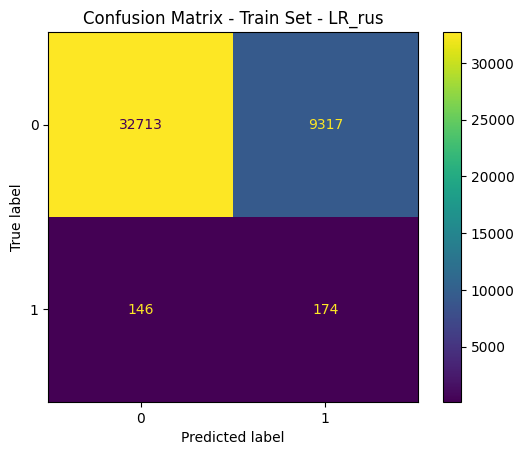

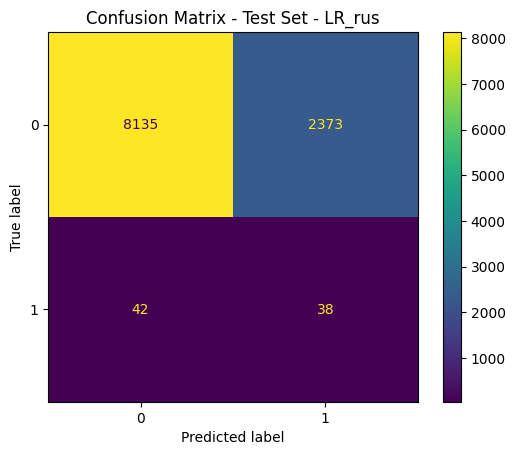

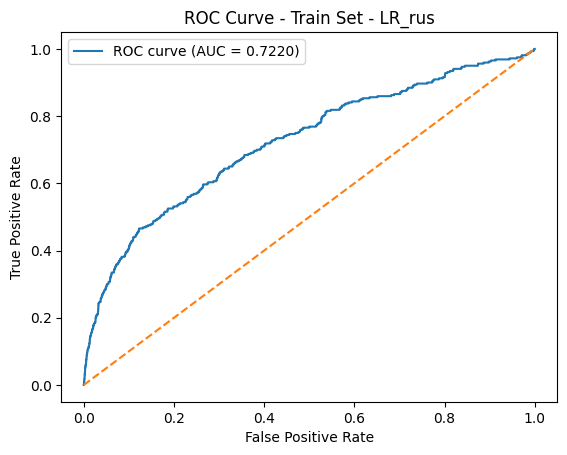

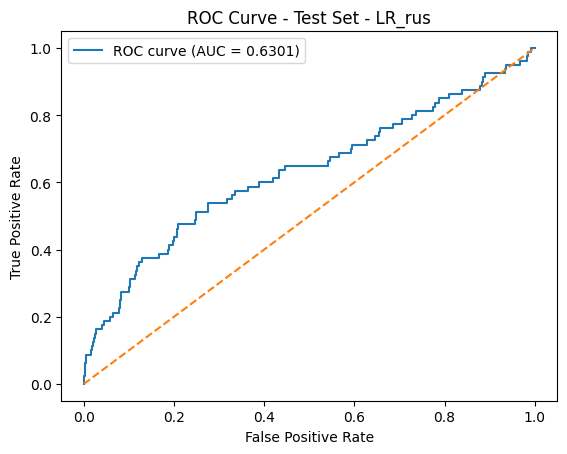

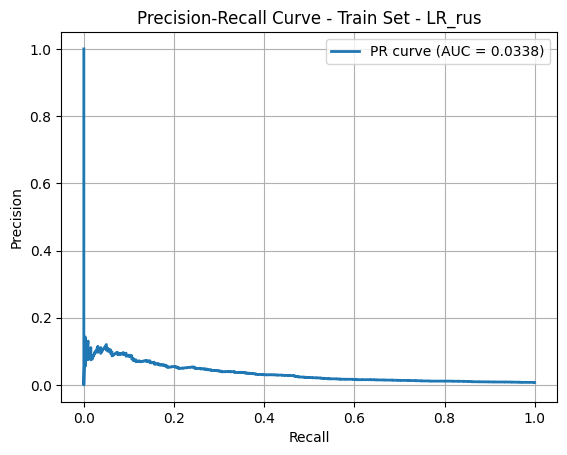

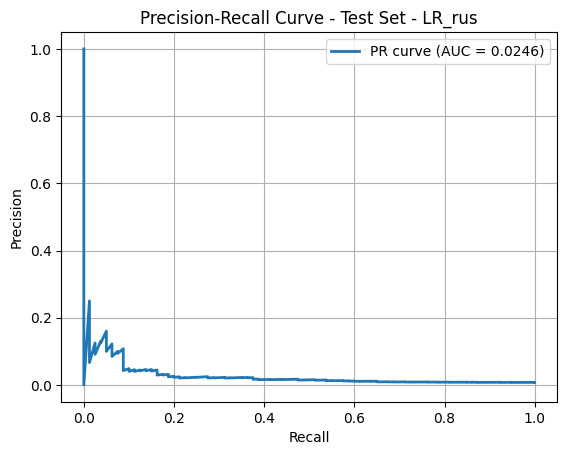

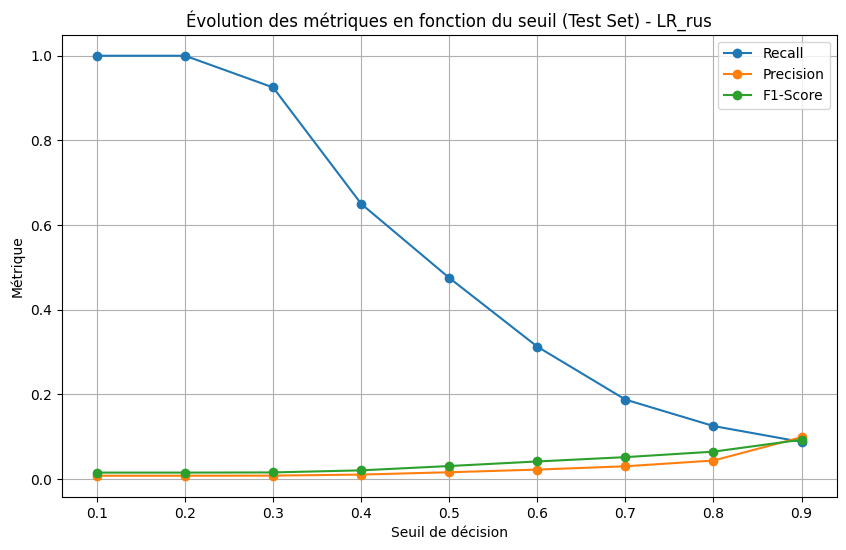

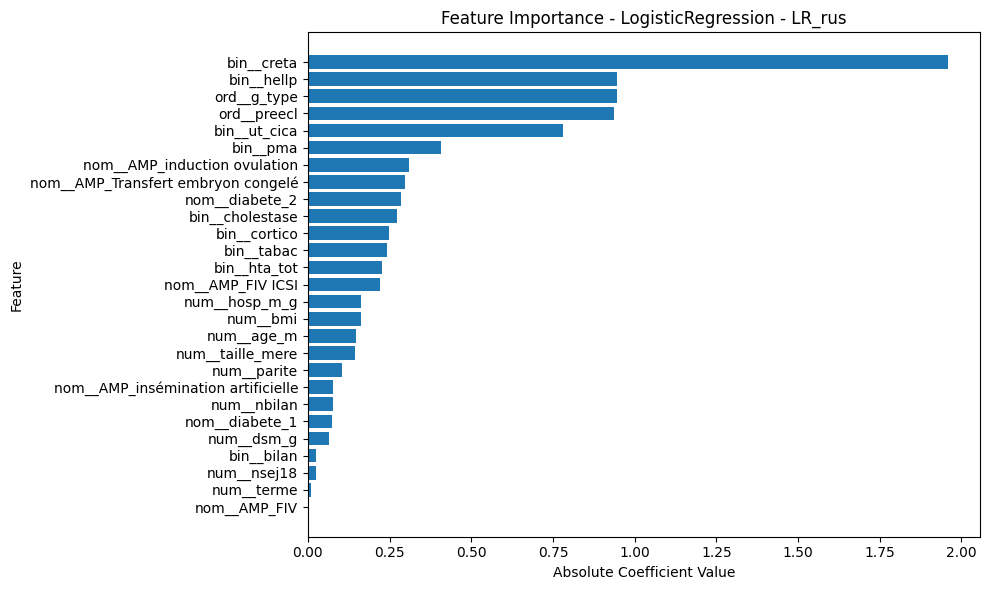

In [62]:
#### 2.2. Rééquilibrage par sous-échantillonnage de la classe majoritaire

# Pipeline avec RandomUnderSampler
pipeline_rus = ImbPipeline(steps=[
    ('preprocessor', preprocessor), 
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', LogisticRegression(random_state=42,max_iter=1000))
])
param_grid = {
    
}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_reg_rus=GridSearchCV(pipeline_rus, param_grid, cv=cv, scoring='f1')
log_reg_rus.fit(X_train,y_train)        


# Évaluation du modèle RUS
rus_results = evaluate_model(log_reg_rus, X_train, X_test, y_train, y_test,
                           experiment_name="LR_prediction", run_name="LR_rus", use_mlflow=False)

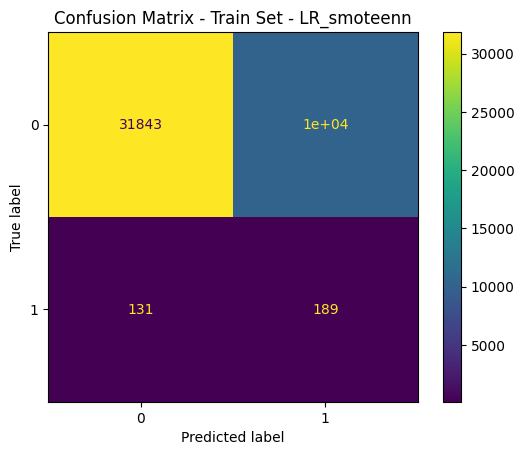

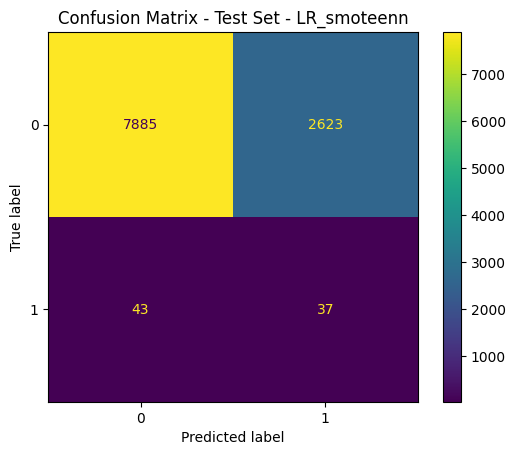

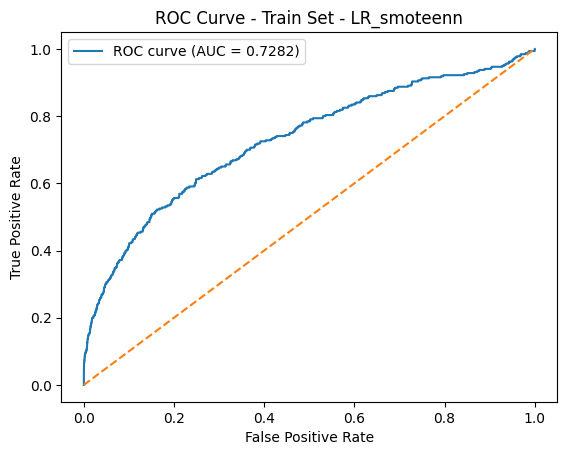

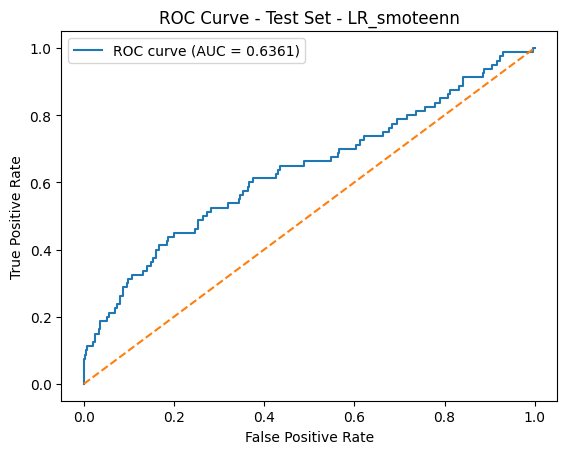

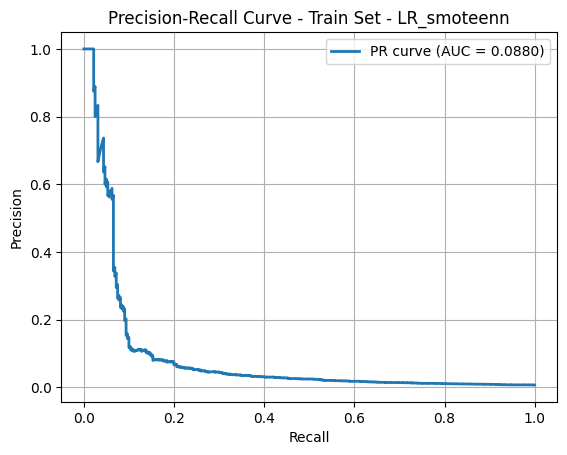

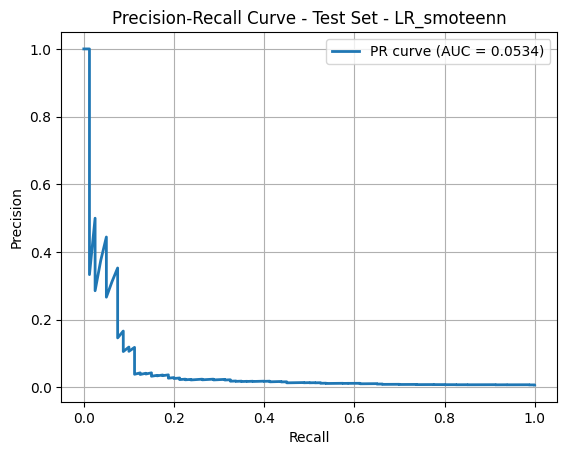

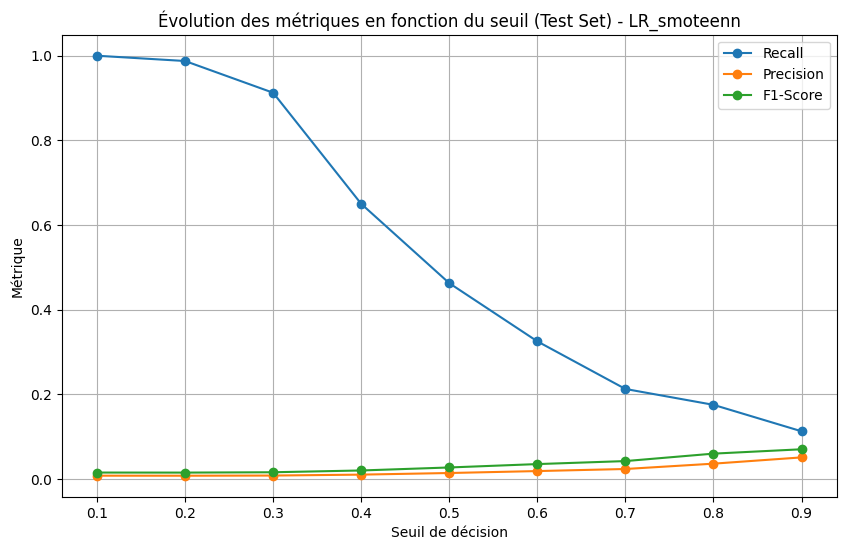

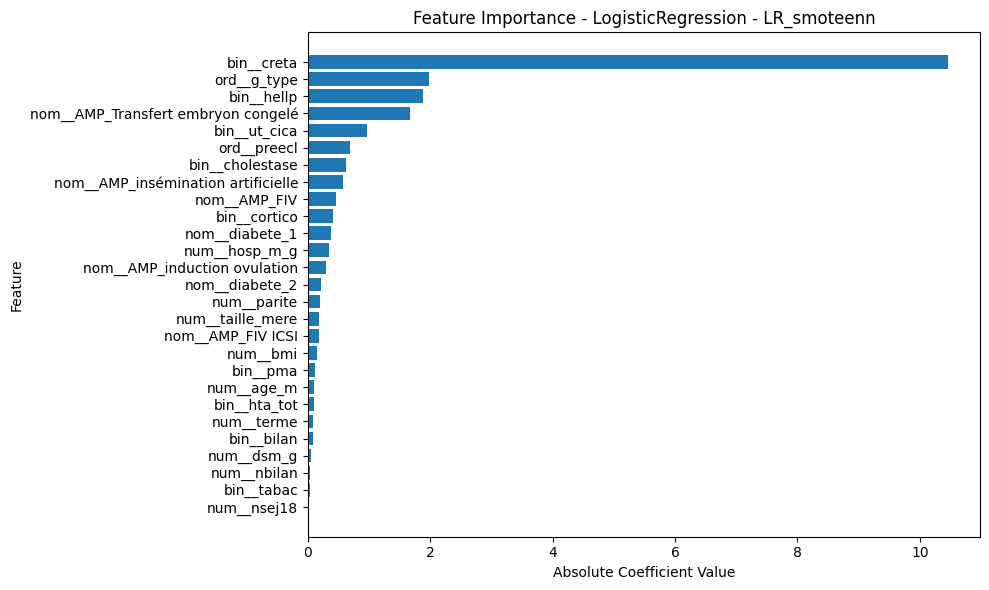

In [63]:
#### 2.3. Rééquilibrage Mixte

# Pipeline avec SMOTEENN
pipeline_smoteenn = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTEENN(random_state=42)),
    ('classifier', LogisticRegression(random_state=42,max_iter=1000))
])
param_grid = {
    
}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_reg_smoteenn=GridSearchCV(pipeline_smoteenn, param_grid, cv=cv, scoring='f1')
log_reg_smoteenn.fit(X_train,y_train)

log_reg_smoteenn_results = evaluate_model(log_reg_smoteenn, X_train, X_test, y_train, y_test,
                                        experiment_name="LR_prediction", run_name="LR_smoteenn", use_mlflow=False)



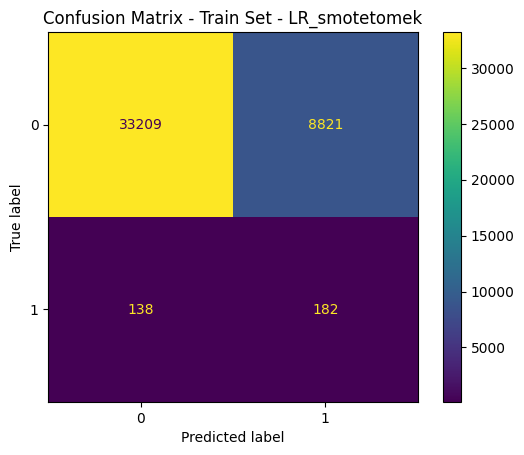

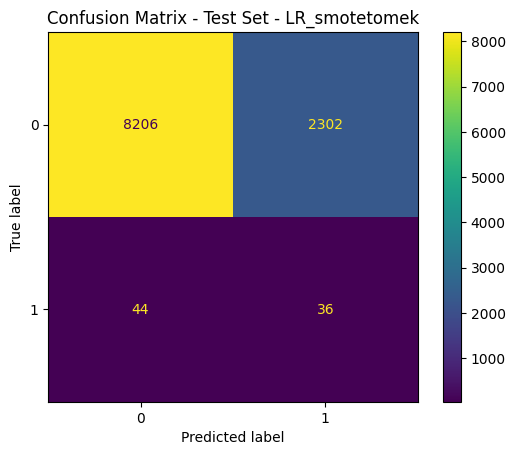

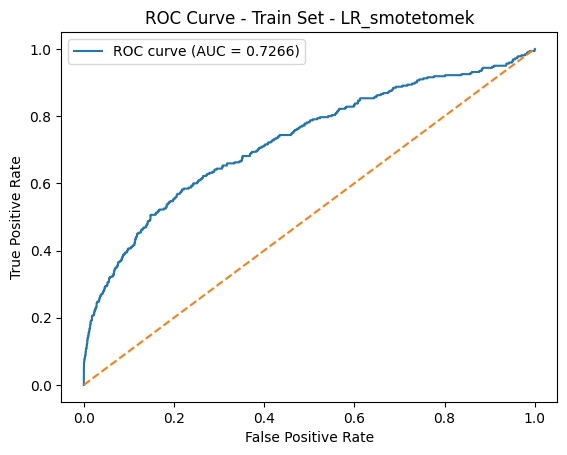

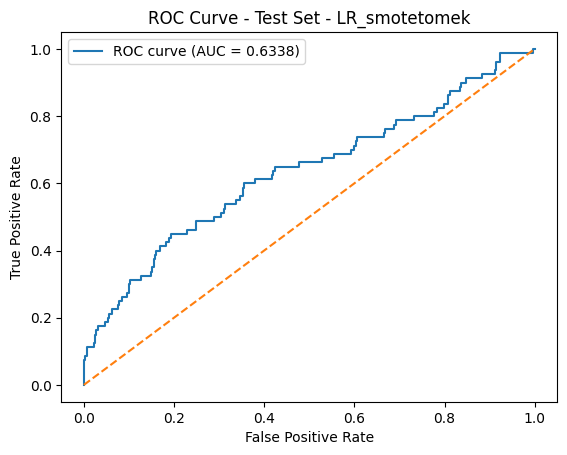

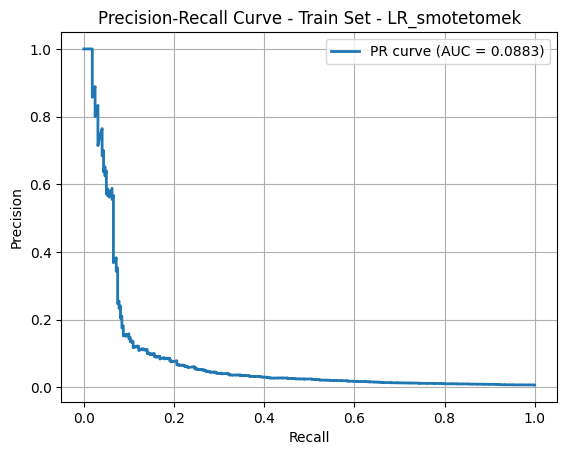

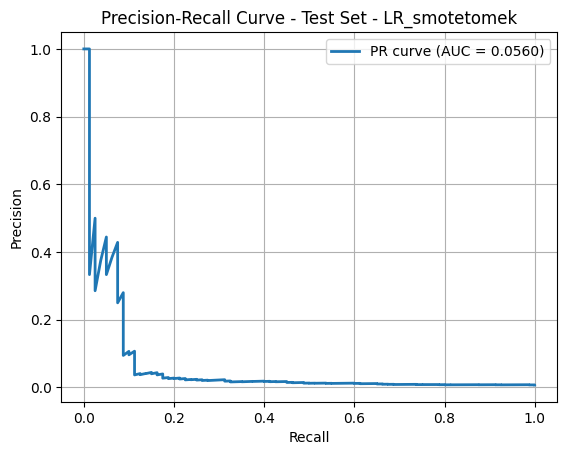

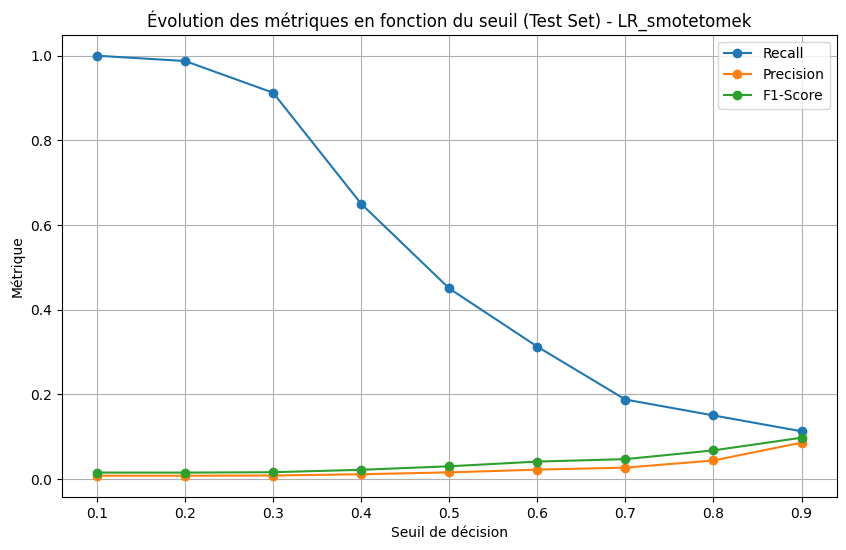

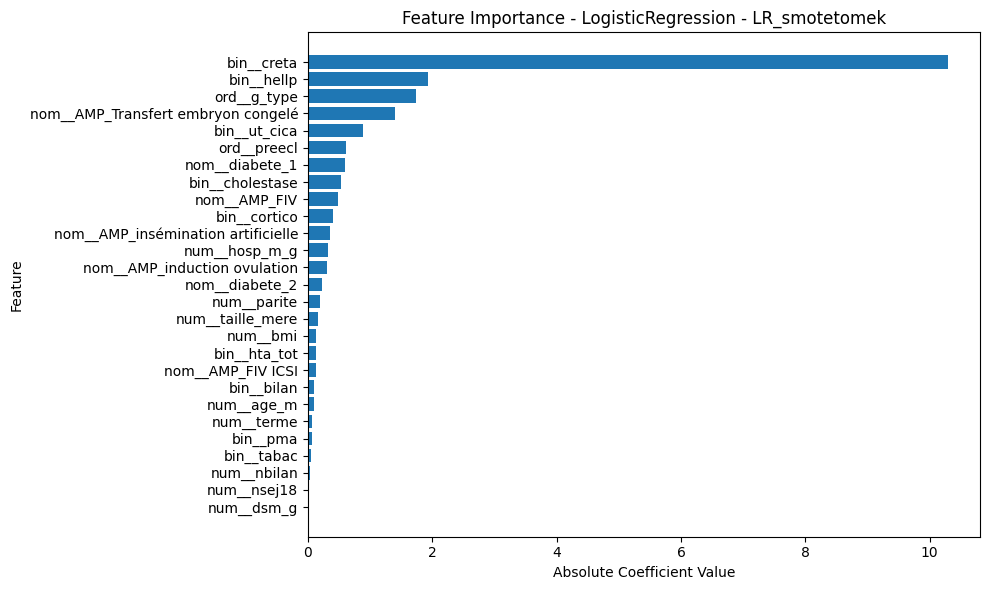

In [64]:
# Pipeline avec SMOTETomek
pipeline_smotetomek = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTETomek(random_state=42)),
    ('classifier', LogisticRegression(random_state=42,max_iter=1000))
])
param_grid = {
    
}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_reg_smotetomek=GridSearchCV(pipeline_smotetomek, param_grid, cv=cv, scoring='f1')
log_reg_smotetomek.fit(X_train,y_train)

log_reg_smotetomek_results = evaluate_model(log_reg_smotetomek, X_train, X_test, y_train, y_test,
                                          experiment_name="LR_prediction", run_name="LR_smotetomek", use_mlflow=False)

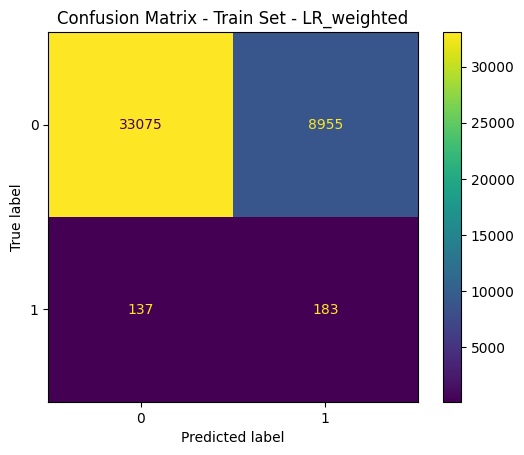

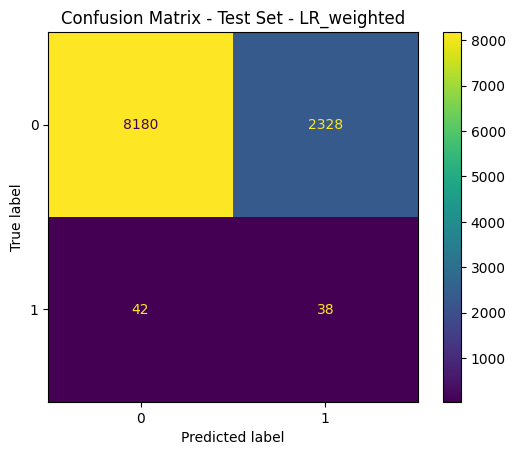

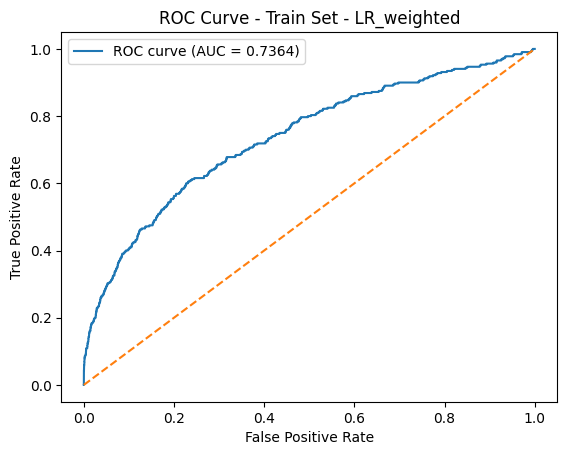

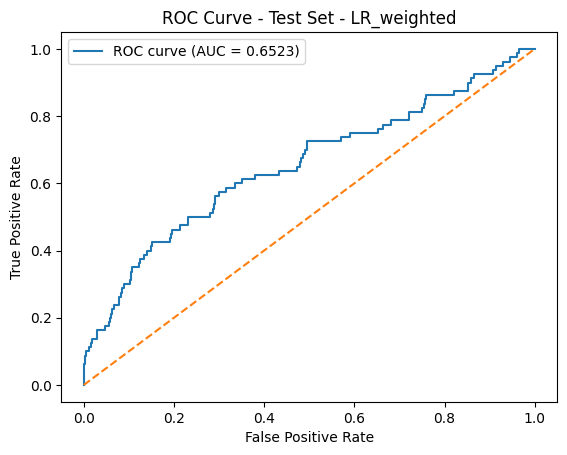

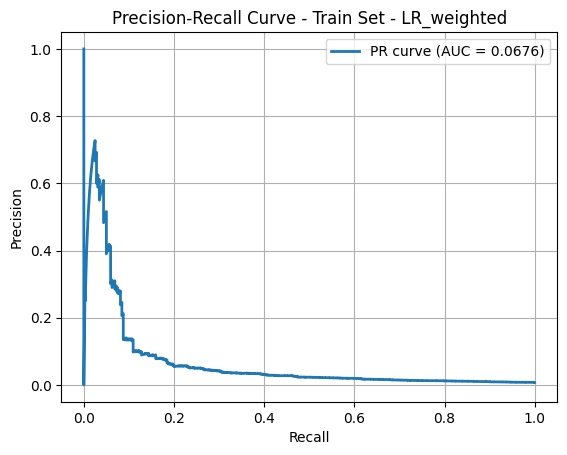

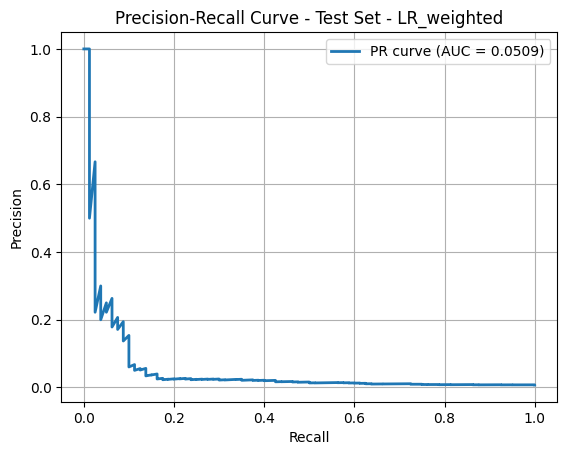

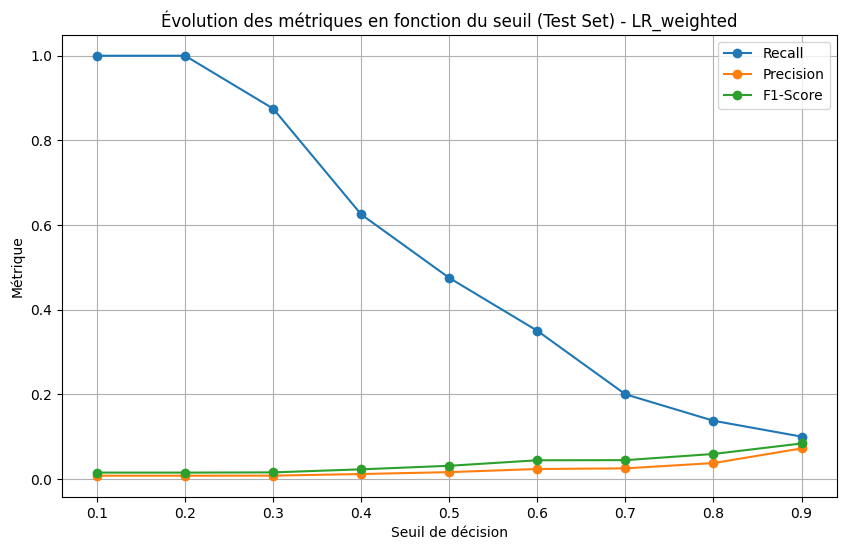

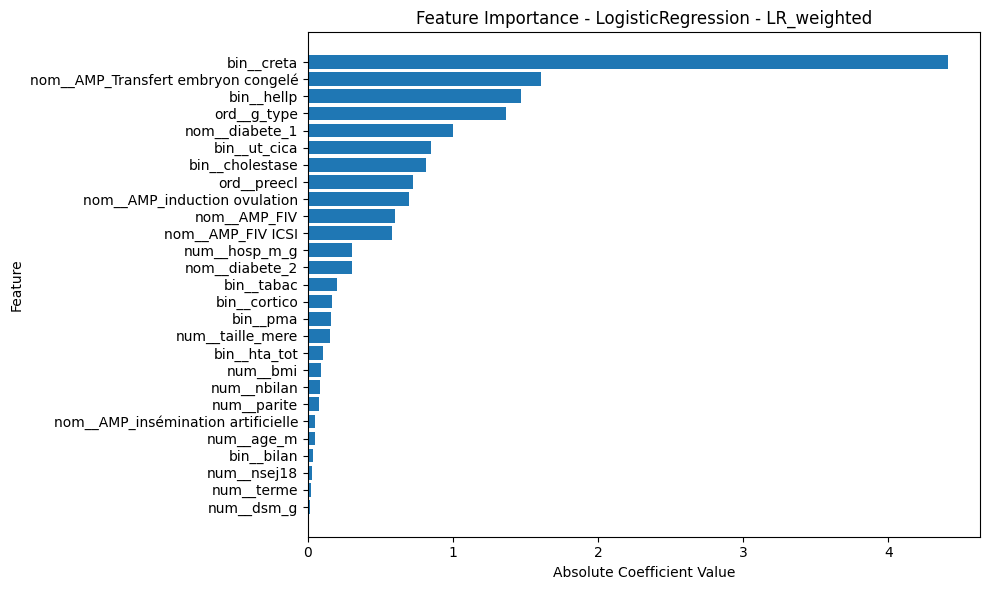

In [65]:
#### 2.4. Rééquilibrage par pondération des classes

# Pipeline avec LogisticRegression pondérée
pipeline_weighted = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced',max_iter=1000))
])
param_grid = {
    
}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_reg_weighted=GridSearchCV(pipeline_weighted, param_grid, cv=cv, scoring='f1')
log_reg_weighted.fit(X_train,y_train)

# Évaluation du modèle pondéré
weighted_results = evaluate_model(log_reg_weighted, X_train, X_test, y_train, y_test,
                                experiment_name="LR_prediction", run_name="LR_weighted", use_mlflow=False)

### Graphique pour comparer les différentes méthodes d'échantillonnage et la baseline

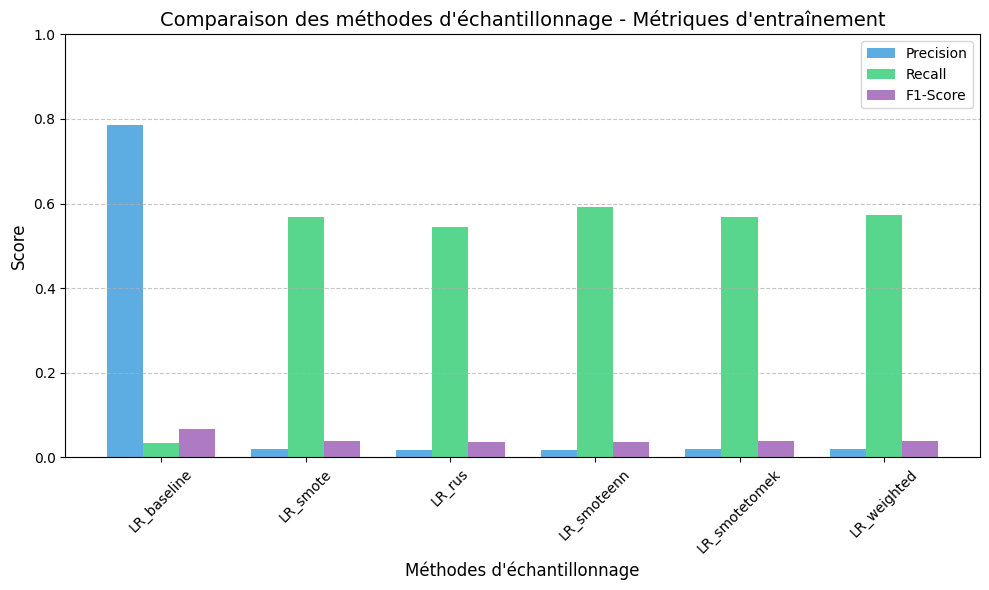

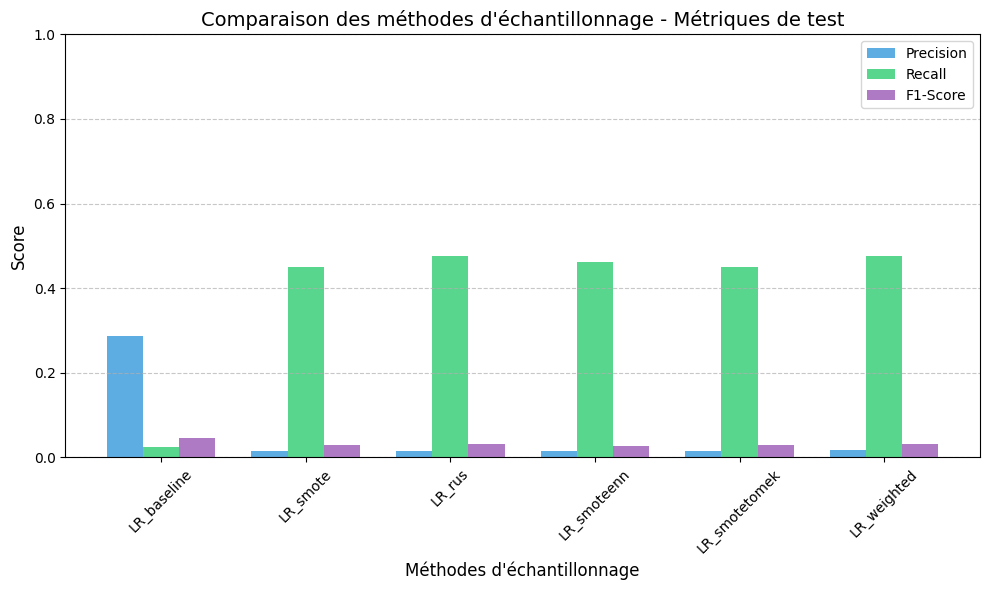

In [66]:
# Création de graphiques séparés pour comparer les différentes méthodes d'échantillonnage
import matplotlib.pyplot as plt
import numpy as np

# Récupération des résultats pour tous les modèles
modeles = ['LR_baseline', 'LR_smote', 'LR_rus', 'LR_smoteenn', 'LR_smotetomek', 'LR_weighted']
resultats = [baseline_results, smote_results, rus_results, log_reg_smoteenn_results, log_reg_smotetomek_results, weighted_results]

# Création d'un dictionnaire pour stocker les métriques d'entraînement et de test
metriques_train = {
    'Precision': [res.get('precision_train', 0) for res in resultats],
    'Recall': [res.get('recall_train', 0) for res in resultats],
    'F1-Score': [res.get('f1_train', 0) for res in resultats],
}

metriques_test = {
    'Precision': [res.get('precision_test', 0) for res in resultats],
    'Recall': [res.get('recall_test', 0) for res in resultats],
    'F1-Score': [res.get('f1_test', 0) for res in resultats],
}

# Couleurs pour les différentes métriques
couleurs = ['#3498db', '#2ecc71', '#9b59b6']  # bleu, vert, violet

# Graphique pour les métriques d'entraînement
fig1 = plt.figure(figsize=(10, 6))
x = np.arange(len(modeles))
largeur = 0.25

for i, metrique in enumerate(['Precision', 'Recall', 'F1-Score']):
    plt.bar(x + (i-1)*largeur, metriques_train[metrique], width=largeur, 
            label=metrique, color=couleurs[i], alpha=0.8)

plt.xlabel('Méthodes d\'échantillonnage', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Comparaison des méthodes d\'échantillonnage - Métriques d\'entraînement', fontsize=14)
plt.xticks(x, modeles, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Graphique pour les métriques de test
fig2 = plt.figure(figsize=(10, 6))

for i, metrique in enumerate(['Precision', 'Recall', 'F1-Score']):
    plt.bar(x + (i-1)*largeur, metriques_test[metrique], width=largeur, 
            label=metrique, color=couleurs[i], alpha=0.8)

plt.xlabel('Méthodes d\'échantillonnage', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Comparaison des méthodes d\'échantillonnage - Métriques de test', fontsize=14)
plt.xticks(x, modeles, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


### 3. Optimisation des hyperparamètres

MLflow désactivé - Les résultats seront affichés uniquement dans le notebook

Évaluation de la méthode: Sans resampling
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs paramètres: {}
Meilleur score F1: 0.0537
Recall correspondant: 0.0281
Precision correspondante: 0.6500

Évaluation de la méthode: SMOTE
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs paramètres: {}
Meilleur score F1: 0.0280
Recall correspondant: 0.4469
Precision correspondante: 0.0145

Évaluation de la méthode: RandomOverSampler
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs paramètres: {}
Meilleur score F1: 0.0356
Recall correspondant: 0.5250
Precision correspondante: 0.0184

Évaluation de la méthode: SMOTEENN
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs paramètres: {}
Meilleur score F1: 0.0283
Recall correspondant: 0.5031
Precision correspondante: 0.0146

Évaluation de la méthode: SMOTETomek
Fitting 5 folds for each of 1 candidates

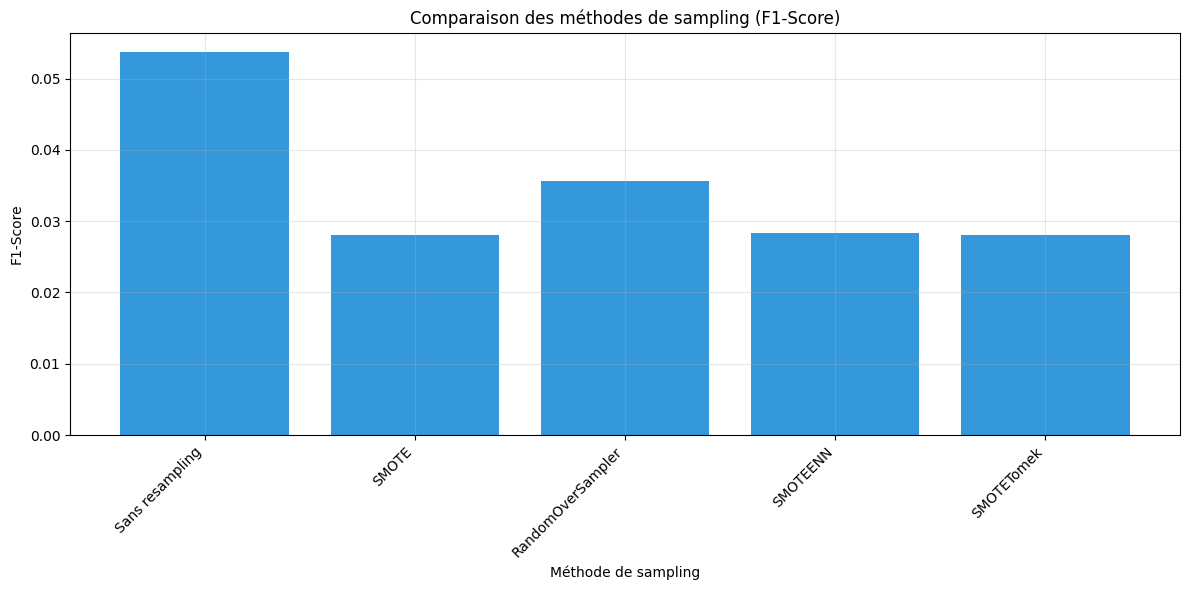

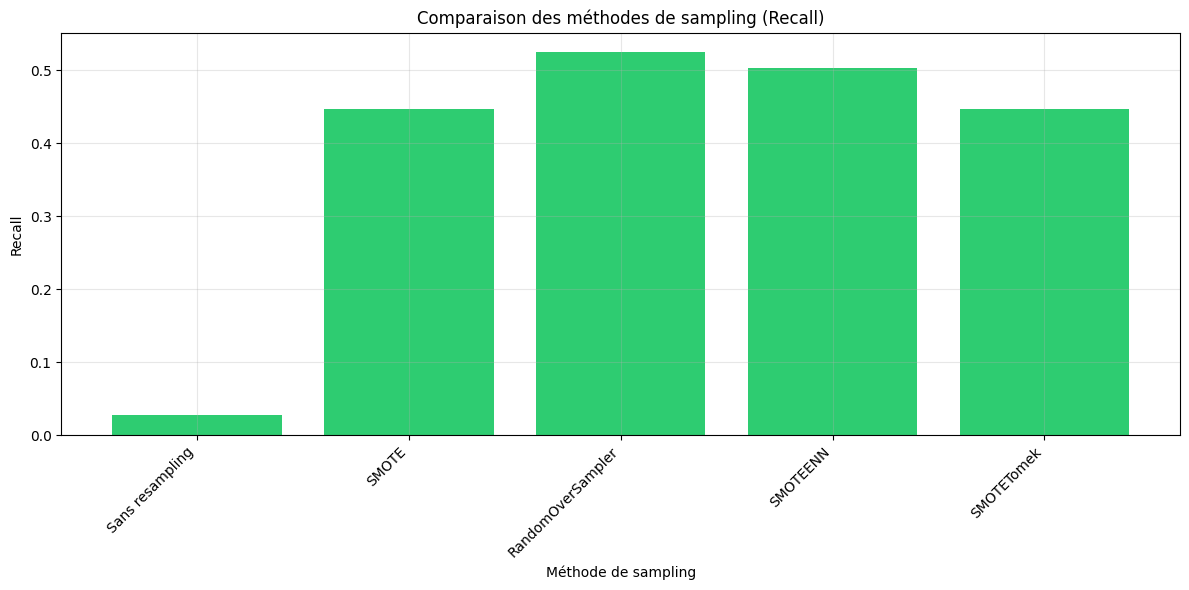

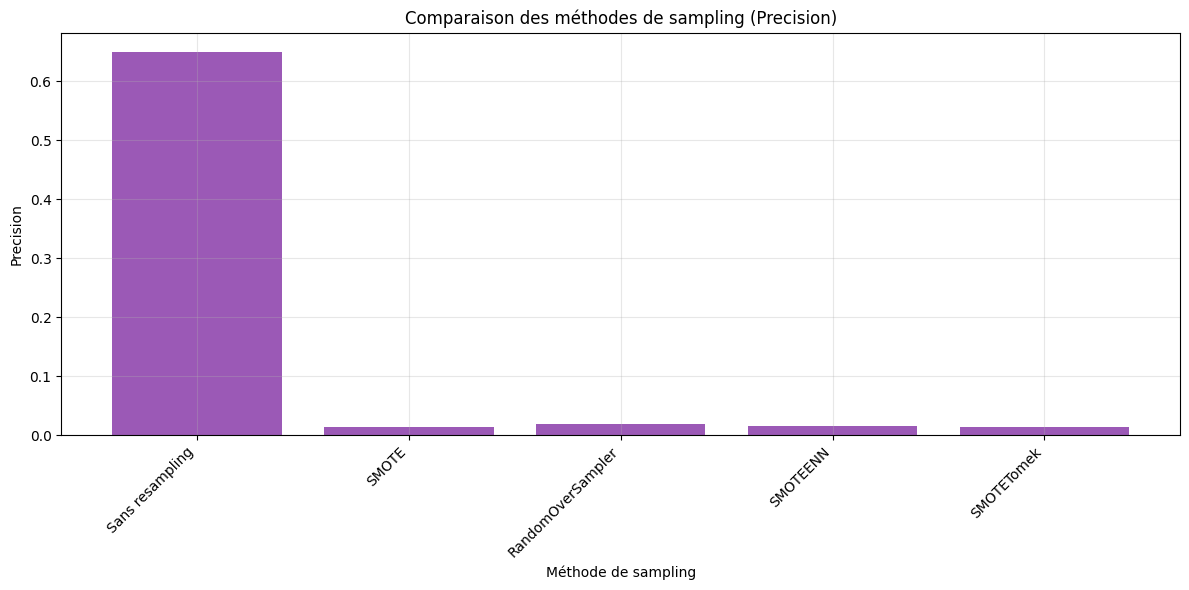

In [85]:
# Optimisation des hyperparamètres avec GridSearchCV pour trouver la meilleure méthode de sampling
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer
import mlflow
import os
import pandas as pd
import warnings

# Suppression des avertissements
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Définition d'une variable pour activer ou désactiver MLflow
use_mlflow = False  # Mettre à True pour activer MLflow, False pour désactiver

if use_mlflow:
    # Configuration de MLflow
    mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "https://thibautmodrin-mlflow.hf.space"))
    mlflow.set_experiment("HPP_Prediction_LogReg_Sampling_Comparison")
    experiment = mlflow.get_experiment_by_name("HPP_Prediction_LogReg_Sampling_Comparison")
    print(f"MLflow activé - Expérience: HPP_Prediction_LogReg_Sampling_Comparison")
else:
    print("MLflow désactivé - Les résultats seront affichés uniquement dans le notebook")

# Définition des différentes méthodes de sampling à tester
samplers = {
    'Sans resampling': None,
    'SMOTE': SMOTE(random_state=42),
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}

# Paramètres pour le modèle de régression logistique et les samplers
param_grid_sans_resampling = {
    # 'classifier__C': [0.01, 0.1, 1, 10, 100],
    # 'classifier__class_weight': [None, 'balanced'],
    # 'classifier__solver': ['liblinear', 'saga']
}

param_grid_smote = {
    # 'sampler__k_neighbors': [3, 5, 7],
    # 'sampler__sampling_strategy': ['auto', 0.5, 0.75, 1.0],
    # 'classifier__C': [0.01, 0.1, 1, 10, 100],
    # 'classifier__class_weight': [None, 'balanced'],
    # 'classifier__solver': ['liblinear', 'saga']
}

param_grid_random_over = {
    # 'sampler__sampling_strategy': ['auto', 0.5, 0.75, 1.0],
    # 'classifier__C': [0.01, 0.1, 1, 10, 100],
    # 'classifier__class_weight': [None, 'balanced'],
    # 'classifier__solver': ['liblinear', 'saga']
}

param_grid_smoteenn = {
    # 'sampler__smote__k_neighbors': [3, 5],
    # 'sampler__sampling_strategy': ['auto', 0.75, 1.0],
    # 'classifier__C': [0.01, 0.1, 1, 10, 100],
    # 'classifier__class_weight': [None, 'balanced'],
    # 'classifier__solver': ['liblinear', 'saga']
}

param_grid_smotetomek = {
    # 'sampler__smote__k_neighbors': [3, 5],
    # 'sampler__sampling_strategy': ['auto', 0.75, 1.0],
    # 'classifier__C': [0.01, 0.1, 1, 10, 100],
    # 'classifier__class_weight': [None, 'balanced'],
    # 'classifier__solver': ['liblinear', 'saga']
}

# Dictionnaire associant chaque sampler à sa grille de paramètres
param_grids = {
    'Sans resampling': param_grid_sans_resampling,
    'SMOTE': param_grid_smote,
    'RandomOverSampler': param_grid_random_over,
    'SMOTEENN': param_grid_smoteenn,
    'SMOTETomek': param_grid_smotetomek
}

# Création d'un dictionnaire pour stocker les résultats
resultats_grid = {}

# Définition des scorers pour les différentes métriques
scorers = {
    'f1': make_scorer(f1_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'precision': make_scorer(precision_score, zero_division=0)
}

# Évaluation de chaque méthode de sampling
for nom_sampler, sampler in samplers.items():
    print(f"\nÉvaluation de la méthode: {nom_sampler}")
    
    # Création du pipeline avec ou sans sampler
    if sampler is None:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(random_state=42, max_iter=1000))
        ])
    else:
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('sampler', sampler),
            ('classifier', LogisticRegression(random_state=42, max_iter=1000))
        ])
    
    # Sélection de la grille de paramètres appropriée
    param_grid = param_grids[nom_sampler]
    
    # Configuration de la recherche par grille avec plusieurs métriques
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=scorers,
        refit='f1',  # Optimisation principale sur F1
        n_jobs=-1,
        verbose=1,
        return_train_score=True
        )
    
    # Gestion de MLflow si activé
    if use_mlflow:
        with mlflow.start_run(run_name=f"LogReg_{nom_sampler}") as run:
            # Enregistrement des paramètres de base
            mlflow.log_param("sampling_method", nom_sampler)
            
            # Création et enregistrement du dataset d'entraînement
            train_df = pd.concat([X_train, y_train], axis=1)
            train_dataset = mlflow.data.from_pandas(
                train_df, name="train_dataset", targets="hpp_trans"
            )
            mlflow.log_input(train_dataset, context="training")
            
            # Exécution de la recherche par grille
            grid_search.fit(X_train, y_train)
            
            # Enregistrement des meilleurs paramètres dans MLflow
            for param_name, param_value in grid_search.best_params_.items():
                mlflow.log_param(param_name, param_value)
            
            # Enregistrement des métriques dans MLflow
            mlflow.log_metric("f1_score", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
            mlflow.log_metric("recall_score", grid_search.cv_results_['mean_test_recall'][grid_search.best_index_])
            mlflow.log_metric("precision_score", grid_search.cv_results_['mean_test_precision'][grid_search.best_index_])
            
            # Enregistrement du modèle dans MLflow avec input_example
            mlflow.sklearn.log_model(
                grid_search.best_estimator_, 
                "model",
                input_example=X_train.iloc[:5]
            )
            
            # Stockage des résultats localement
            resultats_grid[nom_sampler] = {
                'meilleurs_params': grid_search.best_params_,
                'f1_score': grid_search.cv_results_['mean_test_f1'][grid_search.best_index_],
                'recall_score': grid_search.cv_results_['mean_test_recall'][grid_search.best_index_],
                'precision_score': grid_search.cv_results_['mean_test_precision'][grid_search.best_index_],
                'meilleur_estimateur': grid_search.best_estimator_,
                'run_id': run.info.run_id
            }
            
            print(f"Run MLflow ID: {run.info.run_id}")
    else:
        # Exécution de la recherche par grille sans MLflow
        grid_search.fit(X_train, y_train)
        
        # Stockage des résultats localement
        resultats_grid[nom_sampler] = {
            'meilleurs_params': grid_search.best_params_,
            'f1_score': grid_search.cv_results_['mean_test_f1'][grid_search.best_index_],
            'recall_score': grid_search.cv_results_['mean_test_recall'][grid_search.best_index_],
            'precision_score': grid_search.cv_results_['mean_test_precision'][grid_search.best_index_],
            'meilleur_estimateur': grid_search.best_estimator_
        }
    
    print(f"Meilleurs paramètres: {grid_search.best_params_}")
    print(f"Meilleur score F1: {resultats_grid[nom_sampler]['f1_score']:.4f}")
    print(f"Recall correspondant: {resultats_grid[nom_sampler]['recall_score']:.4f}")
    print(f"Precision correspondante: {resultats_grid[nom_sampler]['precision_score']:.4f}")

# Affichage des résultats comparatifs
print("\n=== Résultats comparatifs des méthodes de sampling ===")
for nom_sampler, resultats in resultats_grid.items():
    print(f"{nom_sampler}: F1-Score = {resultats['f1_score']:.4f}, Recall = {resultats['recall_score']:.4f}, Precision = {resultats['precision_score']:.4f}")

# Identification de la meilleure méthode selon F1
meilleure_methode = max(resultats_grid.items(), key=lambda x: x[1]['f1_score'])
print(f"\nLa meilleure méthode est '{meilleure_methode[0]}' avec un F1-Score de {meilleure_methode[1]['f1_score']:.4f}")
print(f"Paramètres optimaux: {meilleure_methode[1]['meilleurs_params']}")

if use_mlflow and 'run_id' in meilleure_methode[1]:
    print(f"Run MLflow ID: {meilleure_methode[1]['run_id']}")

# Visualisation des résultats - Un graphique par métrique
methodes = list(resultats_grid.keys())
couleurs = ['#3498db', '#2ecc71', '#9b59b6']  # bleu, vert, violet

# Graphique pour F1-Score
plt.figure(figsize=(12, 6))
scores_f1 = [resultats['f1_score'] for resultats in resultats_grid.values()]
plt.bar(methodes, scores_f1, color=couleurs[0])
plt.xlabel('Méthode de sampling')
plt.ylabel('F1-Score')
plt.title('Comparaison des méthodes de sampling (F1-Score)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, alpha=0.3)

if use_mlflow:
    plt.savefig("f1_score_comparison.png")
    
plt.show()

# Graphique pour Recall
plt.figure(figsize=(12, 6))
scores_recall = [resultats['recall_score'] for resultats in resultats_grid.values()]
plt.bar(methodes, scores_recall, color=couleurs[1])
plt.xlabel('Méthode de sampling')
plt.ylabel('Recall')
plt.title('Comparaison des méthodes de sampling (Recall)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, alpha=0.3)

if use_mlflow:
    plt.savefig("recall_comparison.png")
    
plt.show()

# Graphique pour Precision
plt.figure(figsize=(12, 6))
scores_precision = [resultats['precision_score'] for resultats in resultats_grid.values()]
plt.bar(methodes, scores_precision, color=couleurs[2])
plt.xlabel('Méthode de sampling')
plt.ylabel('Precision')
plt.title('Comparaison des méthodes de sampling (Precision)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, alpha=0.3)

if use_mlflow:
    plt.savefig("precision_comparison.png")
    
plt.show()

# Enregistrement des graphiques dans MLflow si activé
if use_mlflow:
    with mlflow.start_run(run_name="Comparaison_Globale"):
        mlflow.log_artifact("f1_score_comparison.png")
        mlflow.log_artifact("recall_comparison.png")
        mlflow.log_artifact("precision_comparison.png")
        
        # Enregistrement d'un tableau récapitulatif
        resultats_df = pd.DataFrame({
            'Méthode': methodes,
            'F1-Score': scores_f1,
            'Recall': scores_recall,
            'Precision': scores_precision
        })
        resultats_df.to_csv("resultats_comparatifs.csv", index=False)
        mlflow.log_artifact("resultats_comparatifs.csv")
        
        print("Graphiques et résultats enregistrés dans MLflow")
